# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradients are not different at (0,). Analytic: 6.00000, Numeric: 6.00000
Gradient check passed!
Gradients are not different at (0,). Analytic: 1.00000, Numeric: 1.00000
Gradients are not different at (1,). Analytic: 1.00000, Numeric: 1.00000
Gradient check passed!
Gradients are not different at (0, 0). Analytic: 1.00000, Numeric: 1.00000
Gradients are not different at (0, 1). Analytic: 1.00000, Numeric: 1.00000
Gradients are not different at (1, 0). Analytic: 1.00000, Numeric: 1.00000
Gradients are not different at (1, 1). Analytic: 1.00000, Numeric: 1.00000
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradients are not different at (0,). Analytic: 0.57612, Numeric: 0.57612
Gradients are not different at (1,). Analytic: -0.78806, Numeric: -0.78806
Gradients are not different at (2,). Analytic: 0.21194, Numeric: 0.21194
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradients are not different at (0, 0). Analytic: 0.20603, Numeric: 0.20603
Gradients are not different at (0, 1). Analytic: 0.56005, Numeric: 0.56005
Gradients are not different at (0, 2). Analytic: -0.97212, Numeric: -0.97212
Gradients are not different at (0, 3). Analytic: 0.20603, Numeric: 0.20603
Gradient check passed!
Gradients are not different at (0, 0). Analytic: 0.68145, Numeric: 0.68145
Gradients are not different at (0, 1). Analytic: 0.03393, Numeric: 0.03393
Gradients are not different at (0, 2). Analytic: 0.03393, Numeric: 0.03393
Gradients are not different at (0, 3). Analytic: -0.74931, Numeric: -0.74931
Gradients are not different at (1, 0). Analytic: 0.10923, Numeric: 0.10923
Gradients are not different at (1, 1). Analytic: 0.29692, Numeric: 0.29692
Gradients are not different at (1, 2). Analytic: 0.29692, Numeric: 0.29692
Gradients are not different at (1, 3). Analytic: -0.70308, Numeric: -0.70308
Gradients are not different at (2, 0). Analytic: 0.15216, Numeric: 0.15

In [9]:
np.eye(3)[[2, 1, 1, 0]]

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradients are not different at (0, 0). Analytic: -0.88080, Numeric: -0.88080
Gradients are not different at (0, 1). Analytic: 0.88080, Numeric: 0.88080
Gradients are not different at (1, 0). Analytic: -0.83337, Numeric: -0.83337
Gradients are not different at (1, 1). Analytic: 0.83337, Numeric: 0.83337
Gradients are not different at (2, 0). Analytic: 0.92822, Numeric: 0.92822
Gradients are not different at (2, 1). Analytic: -0.92822, Numeric: -0.92822
Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [11]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradients are not different at (0, 0). Analytic: 0.02000, Numeric: 0.02000
Gradients are not different at (0, 1). Analytic: 0.04000, Numeric: 0.04000
Gradients are not different at (1, 0). Analytic: -0.02000, Numeric: -0.02000
Gradients are not different at (1, 1). Analytic: 0.02000, Numeric: 0.02000
Gradients are not different at (2, 0). Analytic: 0.02000, Numeric: 0.02000
Gradients are not different at (2, 1). Analytic: 0.04000, Numeric: 0.04000
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [12]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 25455.182912
Epoch 1, loss: 26928.310630
Epoch 2, loss: 26611.885157
Epoch 3, loss: 26995.425987
Epoch 4, loss: 27096.880776
Epoch 5, loss: 26210.793847
Epoch 6, loss: 26911.822848
Epoch 7, loss: 25936.854204
Epoch 8, loss: 24215.358505
Epoch 9, loss: 26642.289629


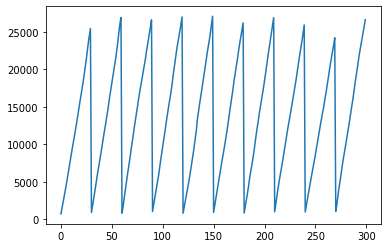

In [13]:
# let's look at the loss history!
plt.plot(loss_history)

In [14]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
loss_history = classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.15
Epoch 0, loss: 25994.650562
Epoch 1, loss: 26920.096406
Epoch 2, loss: 25213.456542
Epoch 3, loss: 28049.569628
Epoch 4, loss: 26689.940869
Epoch 5, loss: 25386.348590
Epoch 6, loss: 25039.112087
Epoch 7, loss: 27265.390094
Epoch 8, loss: 27256.802332
Epoch 9, loss: 28062.113944
Epoch 10, loss: 26052.925354
Epoch 11, loss: 26209.660907
Epoch 12, loss: 27484.413573
Epoch 13, loss: 27446.307671
Epoch 14, loss: 25695.665638
Epoch 15, loss: 26972.530221
Epoch 16, loss: 25808.123091
Epoch 17, loss: 25296.899747
Epoch 18, loss: 27734.807150
Epoch 19, loss: 27202.949737
Epoch 20, loss: 25885.015066
Epoch 21, loss: 26735.523605
Epoch 22, loss: 26820.567161
Epoch 23, loss: 25807.412469
Epoch 24, loss: 26162.520955
Epoch 25, loss: 26714.836530
Epoch 26, loss: 27056.775451
Epoch 27, loss: 25838.665197
Epoch 28, loss: 27364.895207
Epoch 29, loss: 25736.090354
Epoch 30, loss: 27222.549582
Epoch 31, loss: 26052.654146
Epoch 32, loss: 26390.551944
Epoch 33, loss: 28193.099629
Epoch 34

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [15]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

for lr in learning_rates:
    for reg_str in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=reg_str)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if best_val_accuracy is None or best_val_accuracy < accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
        print(lr, reg_str, accuracy)
            
print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 25759.592558
Epoch 1, loss: 25460.946816
Epoch 2, loss: 25151.515980
Epoch 3, loss: 25739.526796
Epoch 4, loss: 25623.892221
Epoch 5, loss: 24492.844342
Epoch 6, loss: 24865.140192
Epoch 7, loss: 24484.315318
Epoch 8, loss: 25725.197654
Epoch 9, loss: 23592.384122
Epoch 10, loss: 24061.580241
Epoch 11, loss: 26129.167136
Epoch 12, loss: 23797.954559
Epoch 13, loss: 23698.613272
Epoch 14, loss: 24952.172215
Epoch 15, loss: 24722.113038
Epoch 16, loss: 23558.893476
Epoch 17, loss: 23934.593422
Epoch 18, loss: 24645.247477
Epoch 19, loss: 24968.534430
Epoch 20, loss: 23108.452481
Epoch 21, loss: 23279.041648
Epoch 22, loss: 24038.211386
Epoch 23, loss: 24041.039260
Epoch 24, loss: 24339.125064
Epoch 25, loss: 24752.907949
Epoch 26, loss: 23670.110499
Epoch 27, loss: 24364.829429
Epoch 28, loss: 24665.140888
Epoch 29, loss: 24334.846817
Epoch 30, loss: 24086.028118
Epoch 31, loss: 23117.325172
Epoch 32, loss: 24218.457961
Epoch 33, loss: 23122.599286
Epoch 34, loss: 23754.66

Epoch 81, loss: 23053.876223
Epoch 82, loss: 23118.220127
Epoch 83, loss: 22655.573412
Epoch 84, loss: 24240.324176
Epoch 85, loss: 23646.835150
Epoch 86, loss: 21541.942275
Epoch 87, loss: 24746.440206
Epoch 88, loss: 22981.770711
Epoch 89, loss: 21651.638458
Epoch 90, loss: 23445.242805
Epoch 91, loss: 21981.157493
Epoch 92, loss: 24679.581035
Epoch 93, loss: 22829.122291
Epoch 94, loss: 22986.733934
Epoch 95, loss: 24407.743759
Epoch 96, loss: 22141.831393
Epoch 97, loss: 22153.829933
Epoch 98, loss: 24163.670127
Epoch 99, loss: 22899.109047
Epoch 100, loss: 23814.504837
Epoch 101, loss: 22931.513681
Epoch 102, loss: 21371.880859
Epoch 103, loss: 22660.708277
Epoch 104, loss: 22160.489656
Epoch 105, loss: 22466.172849
Epoch 106, loss: 22548.639147
Epoch 107, loss: 22656.009650
Epoch 108, loss: 22870.969768
Epoch 109, loss: 22685.621847
Epoch 110, loss: 22887.902765
Epoch 111, loss: 23952.995662
Epoch 112, loss: 21817.728167
Epoch 113, loss: 23341.750652
Epoch 114, loss: 20968.023149

Epoch 158, loss: 24104.405693
Epoch 159, loss: 21619.734906
Epoch 160, loss: 22499.256231
Epoch 161, loss: 22086.868009
Epoch 162, loss: 23190.440741
Epoch 163, loss: 21912.058791
Epoch 164, loss: 20902.965618
Epoch 165, loss: 22145.624591
Epoch 166, loss: 22468.280550
Epoch 167, loss: 20719.769414
Epoch 168, loss: 23469.007567
Epoch 169, loss: 22380.947533
Epoch 170, loss: 22110.142148
Epoch 171, loss: 22873.422774
Epoch 172, loss: 22518.132779
Epoch 173, loss: 23099.964579
Epoch 174, loss: 20890.331637
Epoch 175, loss: 22897.406328
Epoch 176, loss: 22215.706633
Epoch 177, loss: 22042.967517
Epoch 178, loss: 22872.129260
Epoch 179, loss: 23006.434369
Epoch 180, loss: 24316.986264
Epoch 181, loss: 21688.282503
Epoch 182, loss: 22212.710814
Epoch 183, loss: 22171.073199
Epoch 184, loss: 21834.374208
Epoch 185, loss: 22176.094428
Epoch 186, loss: 23349.114027
Epoch 187, loss: 20983.117681
Epoch 188, loss: 23569.097111
Epoch 189, loss: 23194.141231
Epoch 190, loss: 21353.493209
Epoch 191,

Epoch 35, loss: 19145.973308
Epoch 36, loss: 19137.342690
Epoch 37, loss: 19131.520695
Epoch 38, loss: 19118.560758
Epoch 39, loss: 19104.337862
Epoch 40, loss: 19101.840275
Epoch 41, loss: 19089.283360
Epoch 42, loss: 19081.642290
Epoch 43, loss: 19079.270659
Epoch 44, loss: 19060.913334
Epoch 45, loss: 19047.501851
Epoch 46, loss: 19053.614548
Epoch 47, loss: 19043.142942
Epoch 48, loss: 19036.536610
Epoch 49, loss: 19025.882709
Epoch 50, loss: 19021.693876
Epoch 51, loss: 19014.625430
Epoch 52, loss: 19001.563310
Epoch 53, loss: 19000.525963
Epoch 54, loss: 18989.520030
Epoch 55, loss: 18990.485188
Epoch 56, loss: 18978.214053
Epoch 57, loss: 18978.603949
Epoch 58, loss: 18966.232996
Epoch 59, loss: 18967.095228
Epoch 60, loss: 18956.064283
Epoch 61, loss: 18953.660502
Epoch 62, loss: 18950.385949
Epoch 63, loss: 18940.497491
Epoch 64, loss: 18935.127625
Epoch 65, loss: 18925.146242
Epoch 66, loss: 18923.077658
Epoch 67, loss: 18919.045811
Epoch 68, loss: 18913.799487
Epoch 69, loss

Epoch 115, loss: 18727.596613
Epoch 116, loss: 18722.702876
Epoch 117, loss: 18719.336569
Epoch 118, loss: 18719.060131
Epoch 119, loss: 18709.590425
Epoch 120, loss: 18707.059072
Epoch 121, loss: 18703.911200
Epoch 122, loss: 18706.042808
Epoch 123, loss: 18696.082882
Epoch 124, loss: 18697.197155
Epoch 125, loss: 18695.055933
Epoch 126, loss: 18692.919510
Epoch 127, loss: 18682.749643
Epoch 128, loss: 18688.106962
Epoch 129, loss: 18686.075456
Epoch 130, loss: 18674.707844
Epoch 131, loss: 18680.766043
Epoch 132, loss: 18674.458585
Epoch 133, loss: 18672.767326
Epoch 134, loss: 18675.325542
Epoch 135, loss: 18663.778297
Epoch 136, loss: 18660.621702
Epoch 137, loss: 18665.340995
Epoch 138, loss: 18656.758504
Epoch 139, loss: 18652.691895
Epoch 140, loss: 18652.116330
Epoch 141, loss: 18652.870424
Epoch 142, loss: 18648.602884
Epoch 143, loss: 18646.348149
Epoch 144, loss: 18639.737159
Epoch 145, loss: 18640.491606
Epoch 146, loss: 18633.701457
Epoch 147, loss: 18635.315437
Epoch 148,

Epoch 192, loss: 19346.087247
Epoch 193, loss: 19343.970942
Epoch 194, loss: 19341.915445
Epoch 195, loss: 19340.084258
Epoch 196, loss: 19338.065561
Epoch 197, loss: 19335.906796
Epoch 198, loss: 19333.977538
Epoch 199, loss: 19331.859299
1e-05 0.0001 0.231
Epoch 0, loss: 20714.435938
Epoch 1, loss: 20688.456211
Epoch 2, loss: 20664.011852
Epoch 3, loss: 20640.910620
Epoch 4, loss: 20618.412587
Epoch 5, loss: 20597.096391
Epoch 6, loss: 20575.023958
Epoch 7, loss: 20554.934627
Epoch 8, loss: 20533.985073
Epoch 9, loss: 20514.517249
Epoch 10, loss: 20494.722583
Epoch 11, loss: 20475.808699
Epoch 12, loss: 20456.834494
Epoch 13, loss: 20438.615456
Epoch 14, loss: 20420.519398
Epoch 15, loss: 20403.267497
Epoch 16, loss: 20386.330767
Epoch 17, loss: 20369.642620
Epoch 18, loss: 20353.060763
Epoch 19, loss: 20336.260840
Epoch 20, loss: 20320.648682
Epoch 21, loss: 20305.190231
Epoch 22, loss: 20289.719387
Epoch 23, loss: 20274.444956
Epoch 24, loss: 20260.051997
Epoch 25, loss: 20245.6283

Epoch 72, loss: 19778.849663
Epoch 73, loss: 19772.188392
Epoch 74, loss: 19766.194995
Epoch 75, loss: 19759.266750
Epoch 76, loss: 19752.938985
Epoch 77, loss: 19747.185769
Epoch 78, loss: 19740.398119
Epoch 79, loss: 19733.986696
Epoch 80, loss: 19728.764545
Epoch 81, loss: 19722.443030
Epoch 82, loss: 19716.388142
Epoch 83, loss: 19710.613776
Epoch 84, loss: 19704.929480
Epoch 85, loss: 19699.406267
Epoch 86, loss: 19694.266768
Epoch 87, loss: 19688.159972
Epoch 88, loss: 19683.205372
Epoch 89, loss: 19677.888216
Epoch 90, loss: 19672.314187
Epoch 91, loss: 19666.916545
Epoch 92, loss: 19662.025516
Epoch 93, loss: 19657.078306
Epoch 94, loss: 19652.335276
Epoch 95, loss: 19646.773029
Epoch 96, loss: 19642.146672
Epoch 97, loss: 19637.459346
Epoch 98, loss: 19632.569234
Epoch 99, loss: 19627.923446
Epoch 100, loss: 19623.229555
Epoch 101, loss: 19618.150020
Epoch 102, loss: 19614.177490
Epoch 103, loss: 19609.660955
Epoch 104, loss: 19605.109907
Epoch 105, loss: 19600.696684
Epoch 10

# Какой же точности мы добились на тестовых данных?

In [16]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.210000
